In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import numpy as np
from statsmodels.stats import multitest

def pval2star(p):
    if p <= 0.001:
        return '***'
    if p <= 0.01:
        return '**'
    if p <= 0.05:
        return '*'
    return ''

from statsmodels.stats import multitest

def get_adjp(df_pval):
    _, adj_pval, _, _ = multitest.multipletests(df_pval.values.ravel())
    df_adjp = pd.DataFrame(adj_pval.reshape(df_pval.shape), 
                           index = df_pval.index, columns = df_pval.columns)
    return df_adjp

def plot_beta_pval(df_beta, df_pval, adjp = True, ax = None):
    stars = np.array([pval2star(p) for p in df_pval.values.ravel()]).reshape(df_pval.shape)
    #print(stars.shape, df_beta.shape, set([pval2star(p) for p in adj_pval]))
    sns.heatmap(df_beta, cmap = 'RdBu_r', vmax = 0.1, vmin = -0.1, 
                annot=stars, fmt = 's', ax = ax, annot_kws={"size": 12})

In [2]:
df_toptf = pd.read_csv('output/topTFs.csv')

In [3]:
import pickle

with open('output/module_weight.p', 'rb') as reader:
    modules = pickle.load(reader)

In [4]:
df_toptf[df_toptf['celltype'] == 'Mic'].TF.values

array(['ATF5(+)', 'IRF5(+)', 'IRF8(+)', 'SPI1(+)', 'TAL1(+)'],
      dtype=object)

In [5]:

tfs = ['IRF8', 'ATF5', 'SPI1', 'TAL1']
for tf in tfs:
    tf_mods = modules[tf]

    for i, mod in enumerate( tf_mods ):
        print( f'{tf} module {str(i)}: {len(mod)} genes' )

IRF8 module 0: 613 genes
IRF8 module 1: 361 genes
IRF8 module 2: 51 genes
IRF8 module 3: 82 genes
IRF8 module 4: 231 genes
IRF8 module 5: 562 genes
ATF5 module 0: 510 genes
ATF5 module 1: 143 genes
ATF5 module 2: 51 genes
ATF5 module 3: 66 genes
ATF5 module 4: 80 genes
ATF5 module 5: 462 genes
SPI1 module 0: 587 genes
SPI1 module 1: 193 genes
SPI1 module 2: 51 genes
SPI1 module 3: 22 genes
SPI1 module 4: 41 genes
SPI1 module 5: 518 genes
TAL1 module 0: 450 genes
TAL1 module 1: 196 genes
TAL1 module 2: 51 genes
TAL1 module 3: 66 genes
TAL1 module 4: 439 genes


In [6]:
import networkx as nx

In [10]:
scan_genes = set(['OAS1'])

In [12]:
from statsmodels.stats import multitest

df_degs = pd.read_csv('../../degs/dream_v10k_knn/dream_degs.csv')
df_degs = df_degs[(df_degs.Tissue == 'PFC') & (df_degs.CellType == 'Mic')].sort_values('P.Value')
df_qc = pd.read_csv('../../degs/dream_v10k/gene_qc.csv', index_col = 0)

c = 'Mic'
t = 'PFC'
tmp = df[(df.CellType == c) & (df.Tissue == t)]
vec = df_qc['.'.join([c, t])]
vec = set(vec[vec.values > 0.01].index)
tmp = tmp[[g in vec for g in tmp.Gene]]
tmp['fdr'] = multitest.multipletests(tmp['P.Value'].values, method='fdr_bh')[1]
tmp = tmp[tmp.fdr < 0.05].sort_values('P.Value')
degs = set([g for g in tmp.Gene[:50]]) 

In [13]:
import matplotlib.pyplot as plt

In [14]:
with open('output/regulon_scenic.p', 'rb') as reader:
    regulons = pickle.load(reader)
    
df_toptf = pd.read_csv('output/topTFs.csv')

In [15]:
df_toptf

,celltype,TF
0,Ast1,BCL6(+)
1,Ast1,EMX2(+)
2,Ast1,PAX6(+)
3,Ast1,SOX5(+)
4,Ast1,SOX9(+)
...,...,...
70,Peri2,HES4(+)
71,Peri2,HEYL(+)
72,Peri2,NR2F2(+)
73,Peri2,TBX2(+)


In [16]:
df_toptf[df_toptf.TF == 'TAL1(+)']

,celltype,TF
49,Mic,TAL1(+)


In [17]:
for tf in set(df_toptf.TF):
    regs = regulons[tf]
    tmp = set(regs)
    if 'IL10RB' in tmp:
        print(tf, len(tmp), df_toptf[df_toptf.TF == tf])

In [18]:
for tf in tfs:
    tmp = set(regulons[tf + '(+)'])
    print(tf, len(tmp), len(tmp & degs))

IRF8 473 9
ATF5 63 1
SPI1 529 9
TAL1 227 7


In [19]:
df_adj = pd.read_csv('output/adj.tsv', sep = '\t')

In [20]:
df_adj[df_adj.TF == tf].sort_values('importance', ascending = False)

,TF,target,importance
17685,TAL1,PALD1,4.449499e+01
23749,TAL1,P2RY12,3.757170e+01
28587,TAL1,TMEM156,3.336494e+01
29277,TAL1,SRGAP2,3.285388e+01
30256,TAL1,ST6GAL1,3.213291e+01
...,...,...,...
2023716,TAL1,BUB1B,8.098031e-06
2023787,TAL1,PRELID1,7.534113e-06
2025330,TAL1,PHLDA1,6.349487e-07
2025389,TAL1,DCHS2,5.372226e-07


In [21]:
G = nx.DiGraph()

for tf in tfs:
    tf_mods = modules[tf]
    regs = set(regulons[tf + '(+)'])

    for mod in tf_mods:
        mod = sorted(mod.items(), key = lambda x: x[1], reverse=True)
        mod = [g for g in mod if g[0] in regs]
        if not mod:
            continue
        for i, g in enumerate(mod):
            if (i < 10) or (g[0] in degs) or (g[0] in scan_genes):
                G.add_edge(tf, g[0])

(10.901429999999994, 439.52457, -22.761000000000003, 446.961)

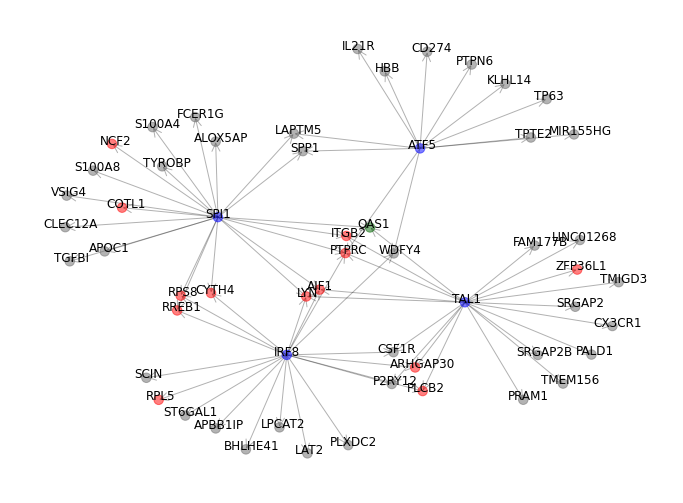

In [22]:
import matplotlib.pyplot as plt

pos = nx.drawing.nx_pydot.graphviz_layout(G)

fig = plt.figure(figsize = (12, 9))
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=1,
    arrowstyle="->",
    arrowsize=20,
    width=1,
    alpha = 0.3,
)
node_color = {g:'dimgray' for g in pos}

for g in pos:
    if g in degs:
        node_color[g] = 'red'

for t in tfs:
    node_color[t] = 'blue'


for t in scan_genes:
    node_color[t] = 'darkgreen'
    
nx.draw_networkx_nodes(G, pos, node_size=90, 
                       node_color=[node_color[n] for n in G.nodes], alpha = 0.5)

for g, (x, y) in pos.items():
    
    plt.text(x - 2*len(g), y, g, fontsize = 12)
#plt.savefig("../../figs/scenic_GRN_mic.pdf")
plt.axis('off')

In [23]:
G = nx.DiGraph()

for tf in tfs:
    #tf_mods = modules[tf]
    tf_key = tf + '(+)'
    regs = set(regulons[tf_key])
    
    targets = df_adj[df_adj.TF == tf].sort_values('importance', ascending = False).target
    
    tmp = (regs - set([tf]))
    assert( set(targets) & tmp == tmp)
    
    targets = [g for g in targets if g in regs]
    
    for i, g in enumerate(targets):
        if (i < 10) or (g in degs) or (g in scan_genes):
            G.add_edge(tf, g)
                

In [24]:
len(set(targets))

226

In [25]:
nx.write_gexf(G,'mic_tf_network.gexf')

(11.407529999999994, 434.19847000000004, -21.6585, 435.3585)

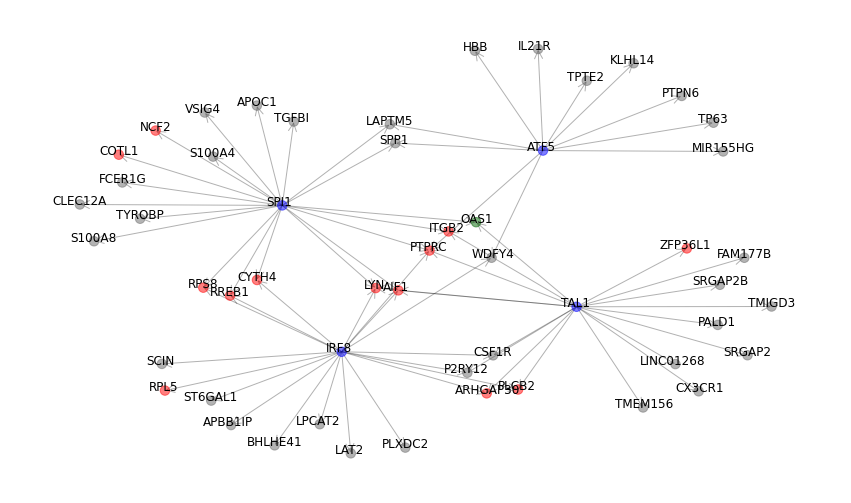

In [26]:
import matplotlib.pyplot as plt

pos = nx.drawing.nx_pydot.graphviz_layout(G)

fig = plt.figure(figsize = (15, 9))

edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=1,
    arrowstyle="->",
    arrowsize=20,
    width=1,
    alpha = 0.3,
)

node_color = {g:'dimgray' for g in pos}

for g in pos:
    if g in degs:
        node_color[g] = 'red'

for t in tfs:
    node_color[t] = 'blue'


for t in scan_genes:
    node_color[t] = 'darkgreen'
    
nx.draw_networkx_nodes(G, pos, node_size=90, 
                       node_color=[node_color[n] for n in G.nodes], alpha = 0.5)

for g, (x, y) in pos.items():
    
    plt.text(x - 2*len(g), y, g, fontsize = 12)
plt.savefig("../../figs/scenic_GRN_mic.pdf")
plt.axis('off')

In [27]:
nx.write_gexf(G, 'mic_tf_network.gexf')